In [18]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [19]:
n_epochs = 30  
n_layers = 1  
n_train = 50  
n_test = 30    

SAVE_PATH = "C://College//College//Quantum Computing//" 
PREPROCESS = True          
np.random.seed(0)           
tf.random.set_seed(0)       

In [20]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

train_images = train_images / 255
test_images = test_images / 255

train_images = np.array(train_images[..., tf.newaxis])
test_images = np.array(test_images[..., tf.newaxis])

(<Figure size 500x500 with 1 Axes>, <Axes: >)

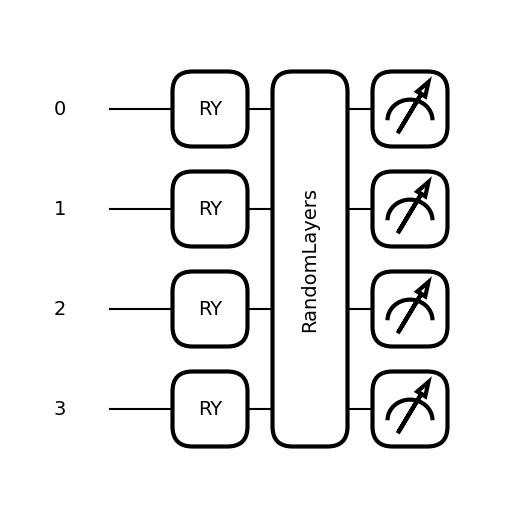

In [6]:
dev = qml.device("default.qubit", wires=4)
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)
    RandomLayers(rand_params, wires=list(range(4)))

    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

qml.draw_mpl(circuit)([np.pi, np.pi/2, np.pi/4, 2*np.pi])

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    for j in range(0, 28, 2):
        for k in range(0, 28, 2):

            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )

            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [8]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")


Quantum pre-processing of train images:
0.00        
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.11764705882352941
0.3686274509803922
0.6666666666666666
0.9921568627450981
0.9921568627450981
0.8823529411764706
0.9921568627450981
0.7647058823529411
0.0
0.0
0.0
0.0
0.0
0.0
0.8588235294117647
0.9921568627450981
0.9921568627450981
0.7764705882352941
0.9686274509803922
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.00392156862745098
0.9921568627450981
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.7450980392156863
0.27450980392156865
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9411764705882353
0.9921568627450981
0.09803921568627451
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.36470588235294116
0.9921568627450981
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1803921568627451
0.7176470588235294
0.9921568627450981
0.00784313725490196
0.0
0.0

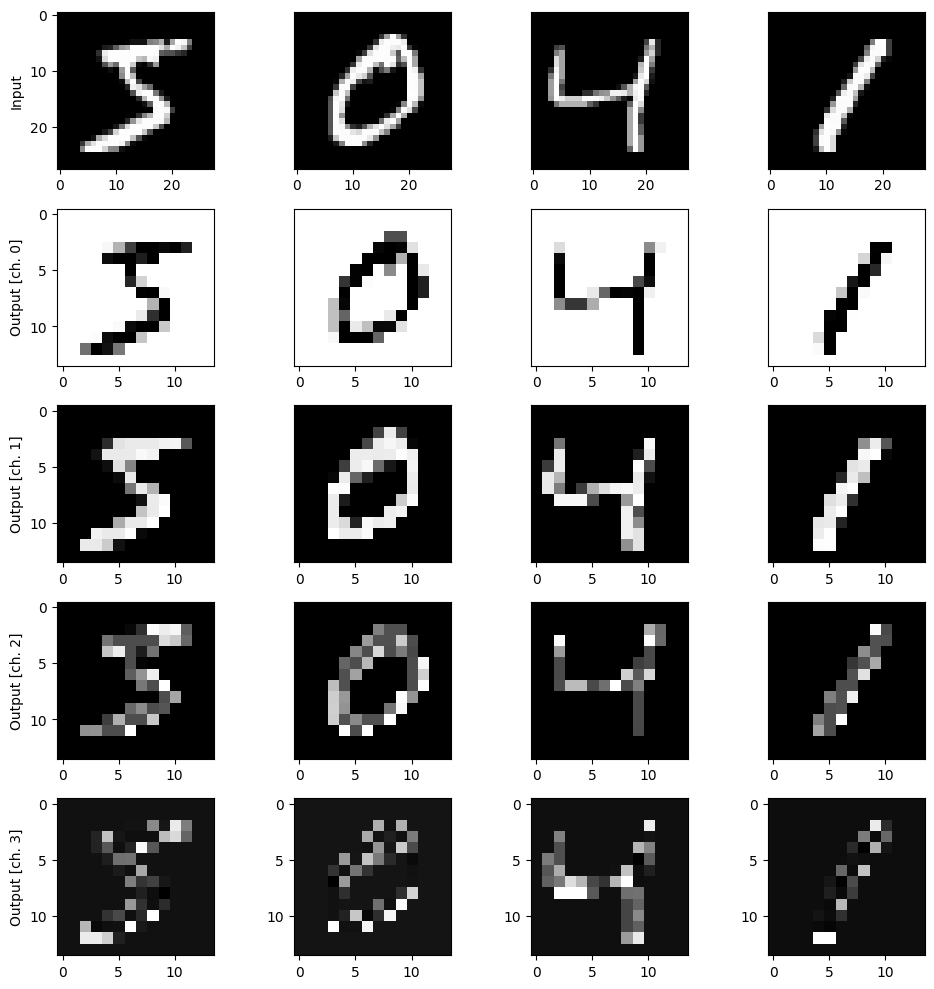

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
def MyModel():
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 49ms/step - accuracy: 0.1400 - loss: 2.7324 - val_accuracy: 0.2000 - val_loss: 2.1432
Epoch 2/30
13/13 - 0s - 8ms/step - accuracy: 0.3800 - loss: 1.8780 - val_accuracy: 0.2333 - val_loss: 1.9982
Epoch 3/30
13/13 - 0s - 9ms/step - accuracy: 0.6600 - loss: 1.5554 - val_accuracy: 0.4000 - val_loss: 1.8301
Epoch 4/30
13/13 - 0s - 9ms/step - accuracy: 0.7800 - loss: 1.2762 - val_accuracy: 0.5000 - val_loss: 1.6797
Epoch 5/30
13/13 - 0s - 8ms/step - accuracy: 0.8600 - loss: 1.0448 - val_accuracy: 0.5333 - val_loss: 1.5649
Epoch 6/30
13/13 - 0s - 9ms/step - accuracy: 0.9000 - loss: 0.8693 - val_accuracy: 0.5667 - val_loss: 1.4830
Epoch 7/30
13/13 - 0s - 8ms/step - accuracy: 0.9200 - loss: 0.7343 - val_accuracy: 0.6000 - val_loss: 1.4122
Epoch 8/30
13/13 - 0s - 8ms/step - accuracy: 0.9600 - loss: 0.6243 - val_accuracy: 0.6667 - val_loss: 1.3486
Epoch 9/30
13/13 - 0s - 9ms/step - accuracy: 0.9600 - loss: 0.5352 - val_accuracy: 0.7333 - val_loss: 1.2976
Epoch 10/30
13/13 

In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 74ms/step - accuracy: 0.1000 - loss: 2.3877 - val_accuracy: 0.3000 - val_loss: 2.1918
Epoch 2/30
13/13 - 0s - 9ms/step - accuracy: 0.3400 - loss: 1.9843 - val_accuracy: 0.3333 - val_loss: 2.0515
Epoch 3/30
13/13 - 0s - 10ms/step - accuracy: 0.5400 - loss: 1.6984 - val_accuracy: 0.4667 - val_loss: 1.9168
Epoch 4/30
13/13 - 0s - 9ms/step - accuracy: 0.7400 - loss: 1.4577 - val_accuracy: 0.5000 - val_loss: 1.7905
Epoch 5/30
13/13 - 0s - 10ms/step - accuracy: 0.8400 - loss: 1.2545 - val_accuracy: 0.5000 - val_loss: 1.6800
Epoch 6/30
13/13 - 0s - 9ms/step - accuracy: 0.8600 - loss: 1.0852 - val_accuracy: 0.5000 - val_loss: 1.5876
Epoch 7/30
13/13 - 0s - 10ms/step - accuracy: 0.8800 - loss: 0.9454 - val_accuracy: 0.5333 - val_loss: 1.5115
Epoch 8/30
13/13 - 0s - 9ms/step - accuracy: 0.9000 - loss: 0.8295 - val_accuracy: 0.5667 - val_loss: 1.4487
Epoch 9/30
13/13 - 0s - 10ms/step - accuracy: 0.9600 - loss: 0.7329 - val_accuracy: 0.6000 - val_loss: 1.3961
Epoch 10/30
13

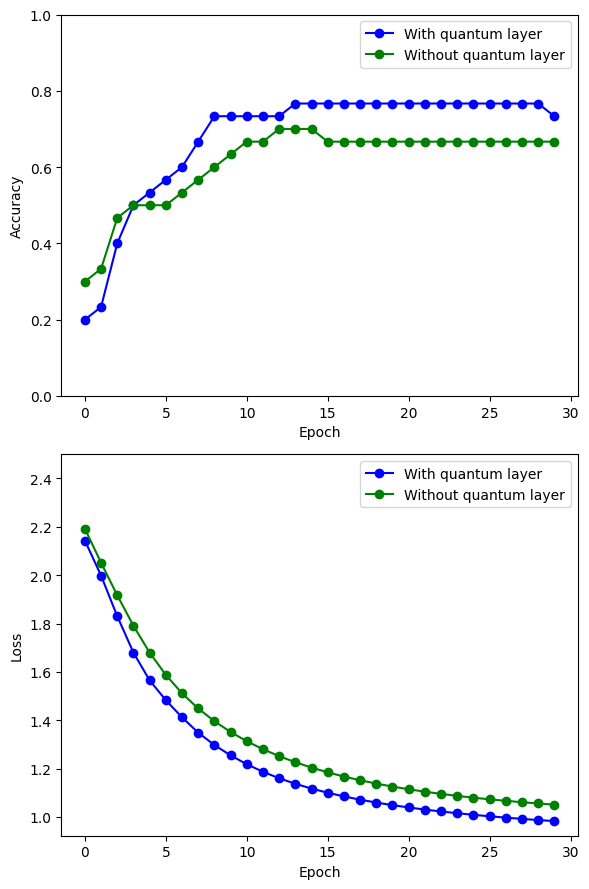

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()